Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - mae: 0.1048 - val_loss: 0.0021 - val_mae: 0.0293
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0429 - val_loss: 5.0211e-04 - val_mae: 0.0145
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mae: 0.0336 - val_loss: 2.6153e-04 - val_mae: 0.0110
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 2.1997e-04 - val_mae: 0.0094
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0257 - val_loss: 2.7011e-04 - val_mae: 0.0115
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 1.7789e-04 - val_mae: 0.0085
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1907e-04 - mae: 0.0221 - val_loss: 1.9723e-04 - val_mae: 0.0097
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2829e-04 - mae: 0.0207 - val_loss: 1.3972e-04 - val_mae: 0.0076
Epoch 9/100


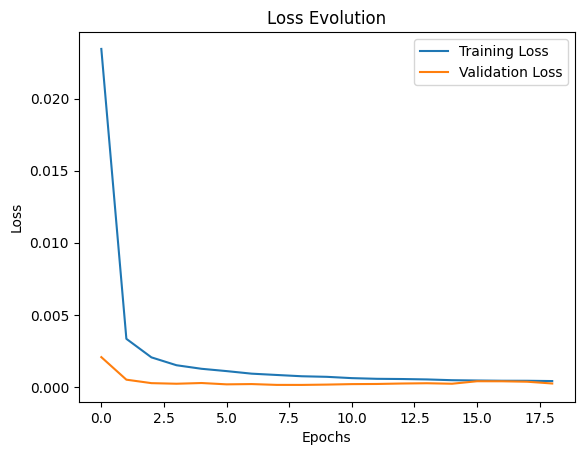

Model saved.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load scalers
scaler_X = joblib.load('../models/scaler_X.pkl')
scaler_y = joblib.load('../models/scaler_y.pkl')

# Reload data and split (for regression on HR)
from sklearn.model_selection import train_test_split
import pandas as pd

# Load merged df (from 01)
TRAIN_TIME = r"D:\Work\Stress_Level_Prediction\data\Train Data\Train Data Zip\time_domain_features_train.csv"
TRAIN_FREQ = r"D:\Work\Stress_Level_Prediction\data\Train Data\Train Data Zip\frequency_domain_features_train.csv"
df_time = pd.read_csv(TRAIN_TIME)
df_freq = pd.read_csv(TRAIN_FREQ)
df = pd.merge(df_time, df_freq, on='uuid', how='inner')

# Sample for speed
df = df.sample(n=10000, random_state=42).reset_index(drop=True)

features = ['MEAN_RR', 'SDRR', 'LF', 'HF']
X = df[features]
y = df['HR'].values.reshape(-1, 1)

X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build NN for regression
model = keras.Sequential([
    layers.Input(shape=(4,)),  # 4 features
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output for regression
])

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Larger batch for big data
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()

model.save('../models/stress_nn_model.h5')
print("Model saved.")